# PlayGround Series

#### Importing libraries

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import holidays

#### Read and merge train and test dataset

In [50]:
train= pd.read_csv("train.csv")
test= pd.read_csv("test.csv")
sample= pd.read_csv('sample_submission.csv')

In [51]:
train.head()

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [52]:
test.head()

,id,date,country,store,product
0,230130,2017-01-01,Canada,Discount Stickers,Holographic Goose
1,230131,2017-01-01,Canada,Discount Stickers,Kaggle
2,230132,2017-01-01,Canada,Discount Stickers,Kaggle Tiers
3,230133,2017-01-01,Canada,Discount Stickers,Kerneler
4,230134,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode


In [53]:
train.isnull().sum()

id             0
date           0
country        0
store          0
product        0
num_sold    8871
dtype: int64

In [54]:
test.isnull().sum()

id         0
date       0
country    0
store      0
product    0
dtype: int64

#### Dataset information
id: Unique Id for each entry</br>
data: Date on which stickers were sold</br>
contry: Country in which the store is located</br>
store: Name of the store</br>
product: Type of stickers</br>

#### Understanding the data

In [55]:
train['num_sold'].isna().sum()

8871

In [56]:
len(train['num_sold'])

230130

In [57]:
train['num_sold'].isna().sum() / len(train['num_sold'])

0.038547777343240774

#### Checking the total percentage of NaN values

In [60]:
for col in train.columns:
    n = train[col].isna().sum() / len(train[col])
    print(f"{col} null: {n.round(3)}")

id null: 0.0
date null: 0.0
country null: 0.0
store null: 0.0
product null: 0.0
num_sold null: 0.039


In [61]:
for col in test.columns:
    n = test[col].isnull().sum() / len(test[col])
    print(f"{col} null : {n.round(3)}")

id null : 0.0
date null : 0.0
country null : 0.0
store null : 0.0
product null : 0.0


#### Checking unique Values

In [63]:
for col in train.columns:
    n = len(train[col].unique())
    print(f'{col} unique : {n}')

id unique : 230130
date unique : 2557
country unique : 6
store unique : 3
product unique : 5
num_sold unique : 4038


In [64]:
for col in test.columns:
    n = len(test[col].unique())
    print(f'{col} unique : {n}')

id unique : 98550
date unique : 1095
country unique : 6
store unique : 3
product unique : 5


#### Exploring and Understanding the Data

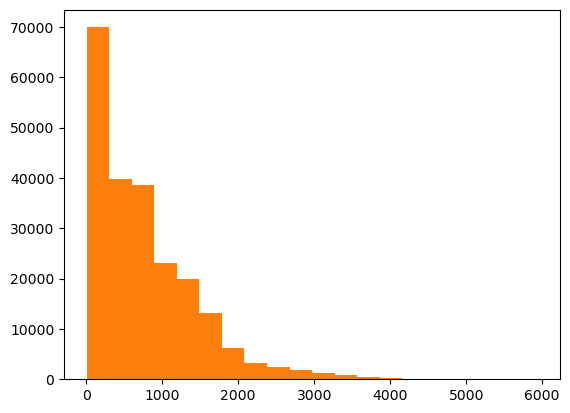

In [67]:
plt.hist(x='num_sold', data = train, bins = 20)
plt.show()

In [91]:
categorical = ['country', 'store', 'product']

In [92]:
df_na = train[train['num_sold'].isna()]
df_na

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
45,45,2010-01-01,Kenya,Discount Stickers,Holographic Goose,NaN
90,90,2010-01-02,Canada,Discount Stickers,Holographic Goose,NaN
135,135,2010-01-02,Kenya,Discount Stickers,Holographic Goose,NaN
180,180,2010-01-03,Canada,Discount Stickers,Holographic Goose,NaN
...,...,...,...,...,...,...
229905,229905,2016-12-29,Kenya,Discount Stickers,Holographic Goose,NaN
229950,229950,2016-12-30,Canada,Discount Stickers,Holographic Goose,NaN
229995,229995,2016-12-30,Kenya,Discount Stickers,Holographic Goose,NaN
230040,230040,2016-12-31,Canada,Discount Stickers,Holographic Goose,NaN


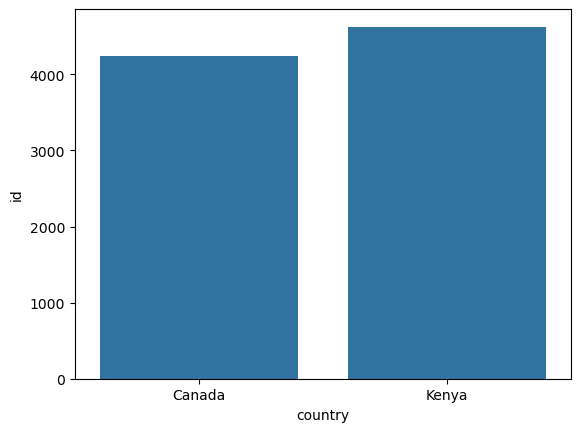

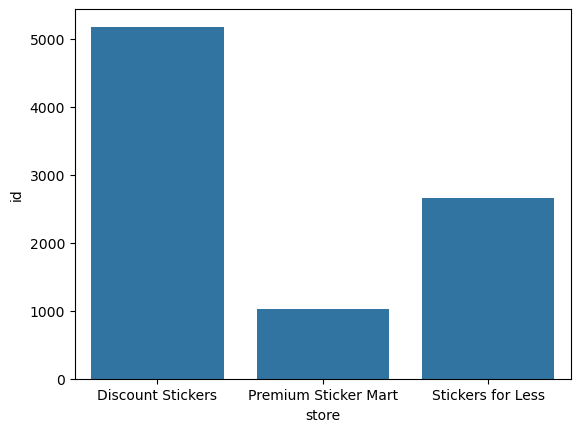

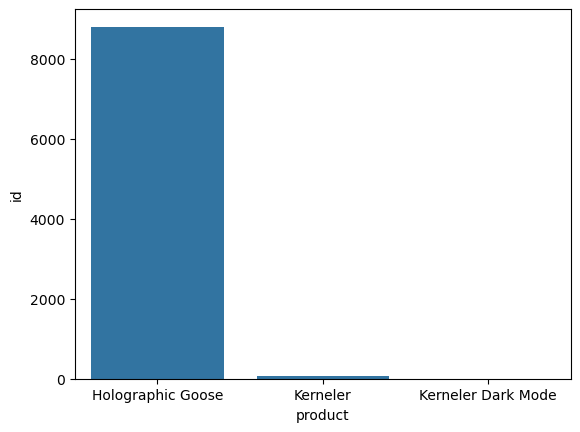

In [97]:
categorical = ['country', 'store', 'product']

df_na = train[train['num_sold'].isna()]

for item in categorical:
    to_plot = df_na.groupby(item, as_index = False).count()
    sns.barplot(
        data = to_plot[to_plot['id']>0],
        x = item,
        y = 'id'
    )
    plt.show()

In [100]:
df['country'].unique()

array(['Canada', 'Finland', 'Italy', 'Kenya', 'Norway', 'Singapore'],
      dtype=object)

#### Feature Engineering

In [118]:
def get_gdp_per_capita (country, year):
    alpha={
        'Canada':'CAN',
        'Finland': 'FIN',
        'Italy': 'ITA',
        'Kenya': 'KEN',
        'Norway' : 'NOR',
        'Singapore' : 'SGP'
    }
    url = f"https://api.worldbank.org/v2/country/{alpha[country]}/indicator/NY.GDP.PCAP.CD?date={year}&format=json"
    response = requests.get(url).json()
    try:
        return response[1][0]['value']
    except (IndexError, TypeError):
        return None

countries = ['Canada', 'Finland', 'Italy',
             'Kenya', 'Norway', 'Singapore']
years = range(2010,2020)
gdp_data = {}

for country in countries:
    for year in years:
        gdp_data[(country, year)] = get_gdp_per_capita(country, year)

In [135]:
def add_gdp_feature(df):
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['gdp'] = df.apply(lambda row:gdp_data.get((row['country'], row['year']), None), axis=1)
    return df

In [136]:
def add_holiday_feature(df):
    country_holidays = {
        'Canada': holidays.CountryHoliday('CA'),
        'Finland': holidays.CountryHoliday('FI'),
        'Italy': holidays.CountryHoliday('IT'),
        'Kenya': holidays.CountryHoliday('KE'),
        'Norway': holidays.CountryHoliday('NO'),
        'Singapore': holidays.CountryHoliday('SG')        
    }

    df['date'] = pd.to_datetime(df['date'])
    df['is_holiday'] = df.apply(
        lambda row: row['date'] in country_holidays.get(row['country'], []), axis=1
        )
    return df

In [137]:
def feature_engineering(train, test):
    train_df = train.copy()
    test_df = test.copy()
    
    train_df = train_df.dropna()

    train_df = add_holiday_feature(train_df)
    test_df = add_holiday_feature(test_df)
    train_df = add_gdp_feature(train_df)
    test_df = add_gdp_feature(test_df)

    product_ratio = train_df.groupby('product')['num_sold'].mean() / train_df['num_sold'].mean()
    store_ratio = train_df.groupby('store')['num_sold'].mean() / train_df['num_sold'].mean()
    country_ratio = train_df.groupby('country')['num_sold'].mean() / train_df['num_sold'].mean()
    product_ratio_mean = product_ratio.mean()
    store_ratio_mean = store_ratio.mean()
    country_ratio_mean = country_ratio.mean()
    for df in [train_df, test_df]:
        df['product_ratio'] = df['product'].map(product_ratio)
        df['store_ratio'] = df['store'].map(store_ratio)
        df['country_ratio'] = df['country'].map(country_ratio)
        df['product_ratio'].fillna(product_ratio_mean, inplace=True)
        df['store_ratio'].fillna(store_ratio_mean, inplace=True)
        df['country_ratio'].fillna(country_ratio_mean, inplace=True)

        df['date'] = df['date'].astype('datetime64[ns]')
        df['year'] = df['date'].dt.year
        df['month'] = df['date'].dt.month
        df['day'] = df['date'].dt.day
        df['day_of_week'] = df['date'].dt.dayofweek
        df["day_of_week"] = df["day_of_week"].apply(lambda x: 0 if x<=3 else(1 if x==4 else (2 if x==5 else (3))))    
        df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
        df["day_of_year"] = df['date'].apply(
            lambda x: x.timetuple().tm_yday if not (x.is_leap_year and x.month > 2) else x.timetuple().tm_yday - 1
        )
        df.drop('date', axis=1, inplace=True)
        df['day_sin4'] = np.sin(df['day_of_year'] * (8 * np.pi /  365.0))
        df['day_cos4'] = np.cos(df['day_of_year'] * (8 * np.pi /  365.0))
        df['day_sin3'] = np.sin(df['day_of_year'] * (6 * np.pi /  365.0))
        df['day_cos3'] = np.cos(df['day_of_year'] * (6 * np.pi /  365.0))
        df['day_sin2'] = np.sin(df['day_of_year'] * (4 * np.pi /  365.0))
        df['day_cos2'] = np.cos(df['day_of_year'] * (4 * np.pi /  365.0))
        df['day_sin'] = np.sin(df['day_of_year'] * (2 * np.pi /  365.0))
        df['day_cos'] = np.cos(df['day_of_year'] * (2 * np.pi /  365.0)) 
        df['day_sin_0.5'] = np.sin(df['day_of_year'] * (1 * np.pi /  365.0))
        df['day_cos_0.5'] = np.cos(df['day_of_year'] * (1 * np.pi /  365.0))    
        df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12.0)
        df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12.0)
        df['year_sin'] = np.sin(2 * np.pi * df['year'] / 7.0)
        df['year_cos'] = np.cos(2 * np.pi * df['year'] / 7.0)
        df['month_country'] = df['month'].astype(str) + "_" + df['country']
        df['month_store'] = df['month'].astype(str) + "_" + df['store']
        df['month_product'] = df['month'].astype(str) + "_" + df['product']

        df['country_store'] = df['country'] + "_" + df['store']
        df['country_product'] = df['country'] + "_" + df['product']
        df['store_product'] = df['store'] + "_" + df['product']
        dummy_columns = [
        'country', 'store', 'product', 
        'month_country', 'month_store','month_product',
        'country_store', 'country_product', 'store_product'
    ]
    train_df = pd.get_dummies(train_df, columns=dummy_columns, drop_first=True)
    test_df = pd.get_dummies(test_df, columns=dummy_columns, drop_first=True)
    
    train_df['num_sold'] = np.log1p(train_df['num_sold'])
    return train_df, test_df


In [138]:
train_df, test_df = feature_engineering(train, test)


C:\Users\abhir\AppData\Local\Temp\ipykernel_2824\77685036.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['product_ratio'].fillna(product_ratio_mean, inplace=True)
C:\Users\abhir\AppData\Local\Temp\ipykernel_2824\77685036.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


In [139]:
train_df.head()

,id,num_sold,is_holiday,year,gdp,product_ratio,store_ratio,country_ratio,month,day,...,store_product_Premium Sticker Mart_Holographic Goose,store_product_Premium Sticker Mart_Kaggle,store_product_Premium Sticker Mart_Kaggle Tiers,store_product_Premium Sticker Mart_Kerneler,store_product_Premium Sticker Mart_Kerneler Dark Mode,store_product_Stickers for Less_Holographic Goose,store_product_Stickers for Less_Kaggle,store_product_Stickers for Less_Kaggle Tiers,store_product_Stickers for Less_Kerneler,store_product_Stickers for Less_Kerneler Dark Mode
1,1,6.881411,True,2010,47560.666601,1.637661,0.568452,1.116298,1,1,...,False,False,False,False,False,False,False,False,False,False
2,2,6.810142,True,2010,47560.666601,1.353232,0.568452,1.116298,1,1,...,False,False,False,False,False,False,False,False,False,False
3,3,6.049733,True,2010,47560.666601,0.740057,0.568452,1.116298,1,1,...,False,False,False,False,False,False,False,False,False,False
4,4,6.198479,True,2010,47560.666601,0.865141,0.568452,1.116298,1,1,...,False,False,False,False,False,False,False,False,False,False
5,5,5.707110,True,2010,47560.666601,0.262428,1.116300,1.116298,1,1,...,False,False,False,False,False,True,False,False,False,False


In [140]:
test_df.head()

,id,is_holiday,year,gdp,product_ratio,store_ratio,country_ratio,month,day,day_of_week,...,store_product_Premium Sticker Mart_Holographic Goose,store_product_Premium Sticker Mart_Kaggle,store_product_Premium Sticker Mart_Kaggle Tiers,store_product_Premium Sticker Mart_Kerneler,store_product_Premium Sticker Mart_Kerneler Dark Mode,store_product_Stickers for Less_Holographic Goose,store_product_Stickers for Less_Kaggle,store_product_Stickers for Less_Kaggle Tiers,store_product_Stickers for Less_Kerneler,store_product_Stickers for Less_Kerneler Dark Mode
0,230130,True,2017,45129.628117,0.262428,0.568452,1.116298,1,1,3,...,False,False,False,False,False,False,False,False,False,False
1,230131,True,2017,45129.628117,1.637661,0.568452,1.116298,1,1,3,...,False,False,False,False,False,False,False,False,False,False
2,230132,True,2017,45129.628117,1.353232,0.568452,1.116298,1,1,3,...,False,False,False,False,False,False,False,False,False,False
3,230133,True,2017,45129.628117,0.740057,0.568452,1.116298,1,1,3,...,False,False,False,False,False,False,False,False,False,False
4,230134,True,2017,45129.628117,0.865141,0.568452,1.116298,1,1,3,...,False,False,False,False,False,False,False,False,False,False


#### Model Training

In [141]:
target = 'num_sold'

In [142]:
train_df.drop('id', axis=1, inplace=True)
X = train_df.drop(target, axis=1)
y = train_df[target]

In [143]:
from sklearn.model_selection import train_test_split

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [147]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

model.fit(X_train, y_train)

LinearRegression()

In [148]:
y_pred = model.predict(X_test)

In [149]:
from sklearn.metrics  import mean_absolute_percentage_error

In [153]:
mape = mean_absolute_percentage_error(y_test, y_pred)

In [154]:
print(mape)

0.014152883461173773


In [156]:
mape_expm1 = mean_absolute_percentage_error(np.expm1(y_test), np.expm1(y_pred))
print(mape_expm1)

0.07037484489416518


#### Submitting

In [157]:
test_df.drop('id',axis=1, inplace=True)
test_df = test_df[X.columns]

In [158]:
y_to_submit = np.expm1(model.predict(test_df))

In [160]:
to_submit = pd.DataFrame(
    data={
        'id': test['id'],
        'num_sold': y_to_submit

    }
)

In [163]:
to_submit.head()

,id,num_sold
0,230130,146.497642
1,230131,920.687018
2,230132,767.964682
3,230133,397.965617
4,230134,511.636336


In [165]:
to_submit.to_csv('to_submit.csv', index=False)